In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Convert categorical columns to string before encoding
df = df.astype(str)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['midas_gender', 'midas_fitzpatrick', 'midas_ethnicity', 'midas_race']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Convert numerical columns to float and handle errors
numerical_cols = ['midas_age', 'length_(mm)', 'width_(mm)']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Normalize numerical variables
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols].fillna(0))

# Define target variable
df['target'] = df['midas_melanoma'].map({'yes': 1, 'no': 0})

# Remove rows with missing labels
df = df.dropna(subset=['target']).reset_index(drop=True)

# Debugging: Check unique label values and types
print("Unique label values:", df["target"].unique())
print("Label data type:", df["target"].dtype)

# Remove rows where the image file is missing
def file_exists(filename):
    possible_paths = [
        os.path.join(image_dir, filename),
        os.path.join(image_dir, filename.replace('.jpg', '.jpeg')),
        os.path.join(image_dir, filename.replace('.jpeg', '.jpg'))
    ]
    return any(os.path.exists(path) for path in possible_paths)

df = df[df['midas_file_name'].apply(file_exists)].reset_index(drop=True)

# Define dataset class
class MRAMIDASDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load image with flexible file extension handling
        img_filename = row['midas_file_name']
        img_path = os.path.join(self.image_dir, img_filename)
        
        if not os.path.exists(img_path):
            # Try alternative extensions
            img_path_jpeg = img_path.replace('.jpg', '.jpeg')
            img_path_jpg = img_path.replace('.jpeg', '.jpg')
            if os.path.exists(img_path_jpeg):
                img_path = img_path_jpeg
            elif os.path.exists(img_path_jpg):
                img_path = img_path_jpg
            else:
                raise FileNotFoundError(f"Image not found: {img_filename}")
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Load metadata
        metadata_values = row[categorical_cols + numerical_cols].values.astype(float)
        metadata = torch.tensor(metadata_values, dtype=torch.float32)
        
        # Ensure label is an integer before creating tensor
        label = int(row['target'])  # Convert from potential object type
        label = torch.tensor(label, dtype=torch.int64)
        
        return image, metadata, label

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images
    transforms.RandomRotation(10),  # Small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


labels = df['target'].values
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[int(t)] for t in labels])
samples_weight = torch.tensor(samples_weight, dtype=torch.float)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
# Create dataset and dataloader
dataset = MRAMIDASDataset(df, image_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)



class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)  # Load pretrained EfficientNet-B0
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 128)  # Adjust output layer
    
    def forward(self, x):
        return self.model(x)


# # Define MLP for metadata processing
# class MetadataModel(nn.Module):
#     def __init__(self, input_size):
#         super(MetadataModel, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         return self.fc(x)


class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Linear(input_dim, input_dim)
    
    def forward(self, x):
        attn_weights = F.softmax(self.W(x), dim=1)
        return x * attn_weights


class MetadataModel(nn.Module):
    def __init__(self, input_size):
        super(MetadataModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            AttentionLayer(128),  # Apply attention to highlight key features
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 32)
        )
    
    def forward(self, x):
        return self.fc(x)



# Define Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, image_model, metadata_model):
        super(MultimodalModel, self).__init__()
        self.image_model = image_model
        self.metadata_model = metadata_model
        self.classifier = nn.Linear(128 + 32, 2)  # Combining both feature sets
    
    def forward(self, image, metadata):
        img_features = self.image_model(image)
        meta_features = self.metadata_model(metadata)
        combined = torch.cat((img_features, meta_features), dim=1)
        return self.classifier(combined)
    


# Move model to GPU
image_model = ImageModel().to(device)
metadata_model = MetadataModel(input_size=len(categorical_cols) + len(numerical_cols)).to(device)
model = MultimodalModel(image_model, metadata_model).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(f"Using device: {device}")
print(f"Class distribution:\n{df['target'].value_counts(normalize=True)}")


# num_epochs = 5
# for epoch in range(num_epochs):
#     start_time = time.time()  # Start timer
#     total_loss = 0
#     correct, total = 0, 0
#     print(f"Started epoch - {epoch+1}")

#     for images, metadata, labels in dataloader:
#         images, metadata, labels = images.to(device), metadata.to(device), labels.to(torch.int64).to(device)
#         model = model.to(device)  # Ensure model is on the correct device
#         optimizer.zero_grad()
#         outputs = model(images, metadata)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)
    
#     accuracy = correct / total
#     epoch_time = time.time() - start_time  # End timer

#     scheduler.step()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f} seconds")


Unique label values: [0. 1.]
Label data type: float64
Using device: cpu
Class distribution:
target
0.0    0.802584
1.0    0.197416
Name: proportion, dtype: float64


c:\Users\91935\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91935\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

num_epochs = 20  # Set epochs to 20
history = {"epoch": [], "loss": [], "accuracy": [], "precision": [], "recall": [], "f1_score": [], "auc_roc": [], "learning_rate": []}

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # Ensure checkpoint directory exists

print(f"Using device: {device}")
print(f"Class distribution:\n{df['target'].value_counts(normalize=True)}")

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    correct, total = 0, 0

    all_labels = []
    all_predictions = []
    all_probs = []

    model.train()  # Ensure the model is in training mode
    print(f"Started epoch - {epoch+1}")

    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(torch.int64).to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute metrics
        total_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()  # Probabilities for positive class
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs)

    # Calculate final metrics
    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    auc_roc = roc_auc_score(all_labels, all_probs)

    # Learning rate tracking
    current_lr = optimizer.param_groups[0]["lr"]

    # Save metrics
    history["epoch"].append(epoch + 1)
    history["loss"].append(total_loss / len(dataloader))
    history["accuracy"].append(accuracy)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1_score"].append(f1)
    history["auc_roc"].append(auc_roc)
    history["learning_rate"].append(current_lr)

    epoch_time = time.time() - start_time  # End timer
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC-ROC: {auc_roc:.4f}, LR: {current_lr:.6f}, Time: {epoch_time:.2f}s")

    # Save model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model checkpoint saved at: {checkpoint_path}")

# Save training history as CSV for visualization later
history_df = pd.DataFrame(history)
history_df.to_csv("training_history.csv", index=False)
print("Training history saved to training_history.csv")


Using device: cpu
Class distribution:
target
0.0    0.802584
1.0    0.197416
Name: proportion, dtype: float64
Started epoch - 1
Epoch 1/20 - Loss: 68.0368, Acc: 0.6280, Prec: 0.6176, Recall: 0.6689, F1: 0.6422, AUC-ROC: 0.6865, LR: 0.001000, Time: 730.82s
Model checkpoint saved at: checkpoints\model_epoch_1.pth
Started epoch - 2
Epoch 2/20 - Loss: 59.6322, Acc: 0.7251, Prec: 0.7090, Recall: 0.7640, F1: 0.7355, AUC-ROC: 0.8031, LR: 0.000976, Time: 506.43s
Model checkpoint saved at: checkpoints\model_epoch_2.pth
Started epoch - 3
Epoch 3/20 - Loss: 53.4034, Acc: 0.7812, Prec: 0.7711, Recall: 0.8146, F1: 0.7922, AUC-ROC: 0.8632, LR: 0.000905, Time: 506.45s
Model checkpoint saved at: checkpoints\model_epoch_3.pth
Started epoch - 4
Epoch 4/20 - Loss: 48.8698, Acc: 0.8281, Prec: 0.8035, Recall: 0.8665, F1: 0.8338, AUC-ROC: 0.9007, LR: 0.000794, Time: 507.14s
Model checkpoint saved at: checkpoints\model_epoch_4.pth
Started epoch - 5
Epoch 5/20 - Loss: 42.6208, Acc: 0.8696, Prec: 0.8528, Recal

In [15]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.model_selection import train_test_split

# Split dataset into train (80%) and test (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["target"])

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Load your trained model
model_path = "checkpoints/model_epoch_15.pth"  # Change this to your final model checkpoint
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Create a DataLoader for your test dataset
test_dataset = MRAMIDASDataset(test_df, image_dir, transform=transform)  # Assuming you have a test dataframe
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_labels = []
all_predictions = []
all_probs = []

# Run inference
with torch.no_grad():
    for images, metadata, labels in test_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(torch.int64).to(device)

        outputs = model(images, metadata)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Probability of class 1
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs)

# Save true labels and predictions
np.save("y_true.npy", np.array(all_labels))
np.save("y_pred.npy", np.array(all_predictions))
np.save("y_probs.npy", np.array(all_probs))

print("Saved predictions and labels successfully!")

Train size: 2662, Test size: 666


C:\Users\91935\AppData\Local\Temp\ipykernel_28728\4043802466.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

Saved predictions and labels successfully!


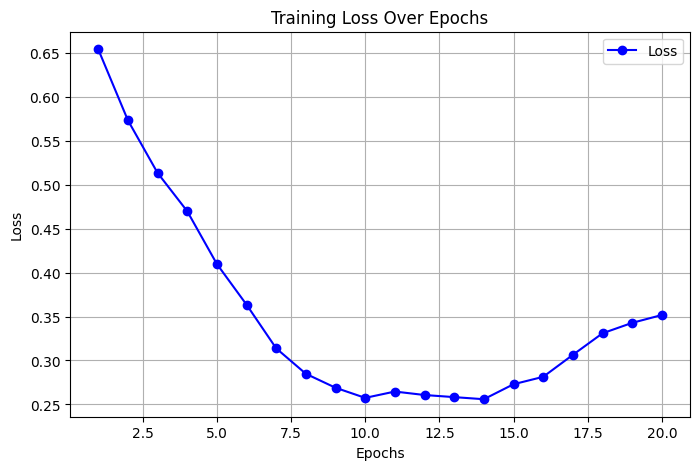

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

history_df = pd.read_csv("training_history.csv")  # Load your saved training history

plt.figure(figsize=(8, 5))
plt.plot(history_df["epoch"], history_df["loss"], marker='o', linestyle='-', label="Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

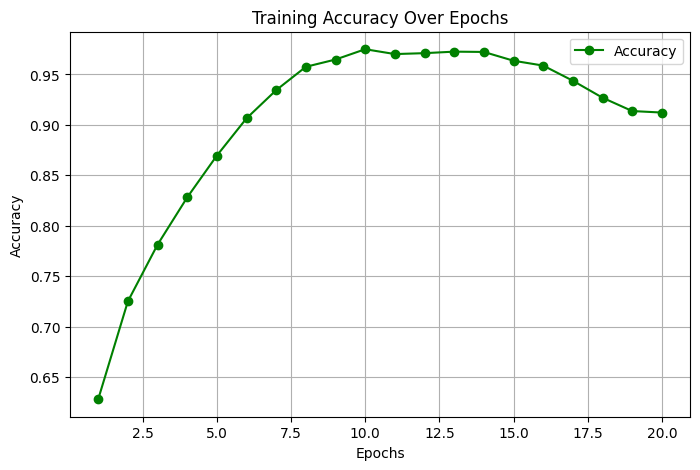

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(history_df["epoch"], history_df["accuracy"], marker='o', linestyle='-', label="Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

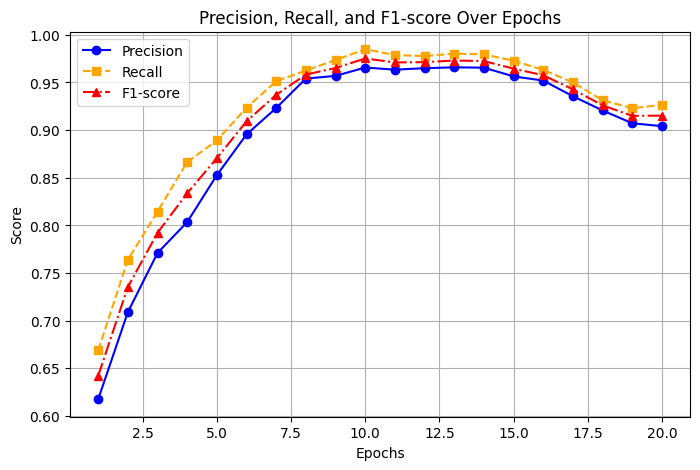

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(history_df["epoch"], history_df["precision"], marker='o', linestyle='-', label="Precision", color="blue")
plt.plot(history_df["epoch"], history_df["recall"], marker='s', linestyle='--', label="Recall", color="orange")
plt.plot(history_df["epoch"], history_df["f1_score"], marker='^', linestyle='-.', label="F1-score", color="red")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

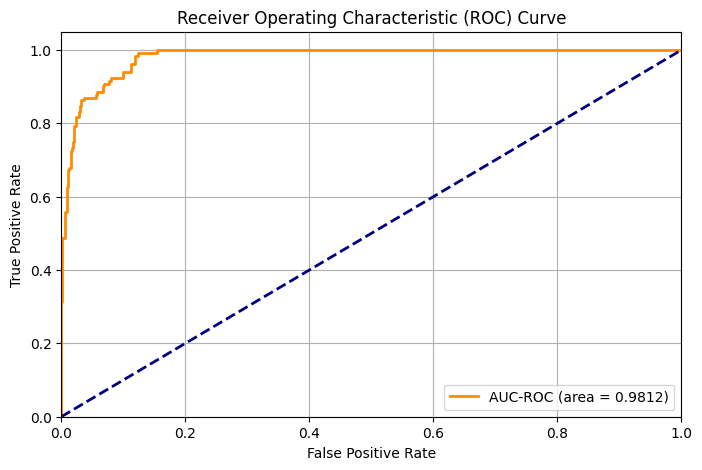

In [11]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Load labels and probabilities (ensure these are stored from the test phase)
y_true = np.load("y_true.npy")  # Replace with actual file path if stored in CSV
y_probs = np.load("y_probs.npy")  # Replace with actual file path

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC-ROC (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

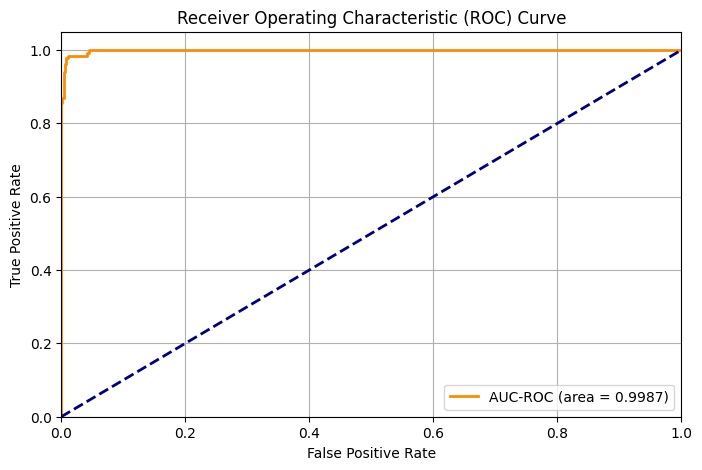

In [16]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Load labels and probabilities (ensure these are stored from the test phase)
y_true = np.load("y_true.npy")  # Replace with actual file path if stored in CSV
y_probs = np.load("y_probs.npy")  # Replace with actual file path

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC-ROC (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

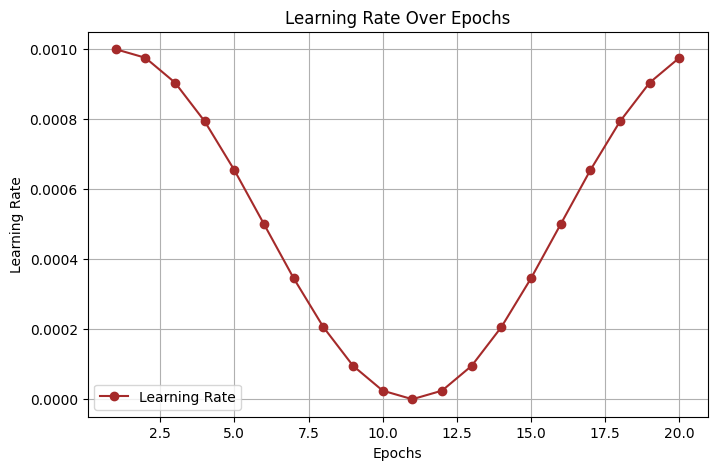

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(history_df["epoch"], history_df["learning_rate"], marker='o', linestyle='-', label="Learning Rate", color="brown")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 600x600 with 0 Axes>

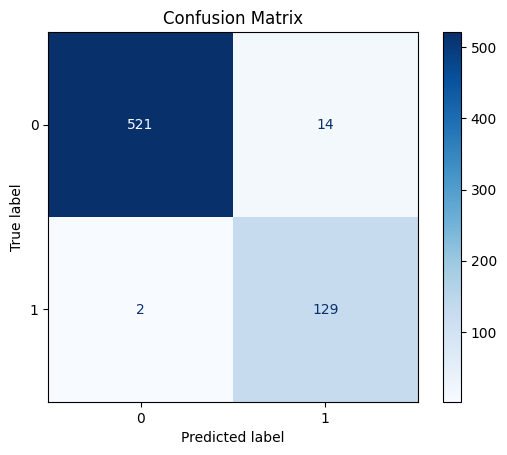

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.load("y_pred.npy")  # Replace with your actual predictions
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9760


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Load saved true labels and predictions
y_true = np.load("y_true.npy")
y_pred = np.load("y_pred.npy")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Compute Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Accuracy from Confusion Matrix: {accuracy:.4f}")

Accuracy from Confusion Matrix: 0.9760


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load saved true labels and predictions
y_true = np.load("y_true.npy")  # True labels
y_pred = np.load("y_pred.npy")  # Predicted labels
y_probs = np.load("y_probs.npy")  # Probability scores for ROC-AUC

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_probs)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9760
Precision: 0.9021
Recall: 0.9847
F1 Score: 0.9416
ROC-AUC: 0.9987


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchcam.methods import SmoothGradCAMpp
from torchvision import models
from PIL import Image

# Load the trained model
model_path = "checkpoints/model_epoch_15.pth"  # Update this if needed
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

# Define image transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select an image for Grad-CAM
image_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/s-prd-416793404.jpg"  # Change this to an actual test image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Select the target layer (final convolutional layer in EfficientNet-B0)
target_layer = model.image_model.model.features[-1]

# Initialize Grad-CAM
cam_extractor = SmoothGradCAMpp(model, target_layer)

# Get model output and Grad-CAM heatmap
output = model(input_tensor, torch.zeros(1, len(categorical_cols) + len(numerical_cols)))  # Pass dummy metadata
predicted_class = output.argmax(dim=1).item()
activation_map = cam_extractor(predicted_class, output)

# Convert heatmap to numpy
heatmap = activation_map[0].squeeze().cpu().detach().numpy()

# Display image and heatmap overlay
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# Grad-CAM Heatmap Overlay
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap
plt.axis("off")
plt.title("Grad-CAM Heatmap")

plt.show()


C:\Users\91935\AppData\Local\Temp\ipykernel_28728\780032541.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

TypeError: MultimodalModel.forward() missing 1 required positional argument: 'metadata'

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchcam.methods import SmoothGradCAMpp
import torchvision.transforms.functional as TF
from PIL import Image

# Load the trained model
model_path = "checkpoints/model_epoch_15.pth"  # Update this path
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

# Define image transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select an image from the test set
image_filename = "s-prd-766393515.jpg"  # Change to an actual filename from test_df
image_path = os.path.join(image_dir, image_filename)

# Load and process the image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# ✅ **Find the corresponding metadata row**
metadata_row = test_df[test_df["midas_file_name"] == image_filename]

# If no metadata found, raise an error
if metadata_row.empty:
    raise ValueError(f"No metadata found for image: {image_filename}")

# ✅ **Extract actual metadata**
metadata_values = metadata_row[categorical_cols + numerical_cols].values.astype(float)
metadata_tensor = torch.tensor(metadata_values, dtype=torch.float32)
metadata_tensor = metadata_tensor.squeeze(1) 
# # Ensure metadata is correctly shaped
# metadata_tensor = metadata_tensor.unsqueeze(0)  # Add batch dimension

# Move model and data to CPU for Grad-CAM
model.cpu()
input_tensor = input_tensor.cpu()
metadata_tensor = metadata_tensor.cpu()

# Select the target layer (final convolutional layer in EfficientNet-B0)
target_layer = model.image_model.model.features[-1]

# Initialize Grad-CAM
cam_extractor = SmoothGradCAMpp(model.image_model, target_layer)

# Get model output and Grad-CAM heatmap
output = model(input_tensor, metadata_tensor)  # Pass **actual metadata**
predicted_class = output.argmax(dim=1).item()
activation_map = cam_extractor(predicted_class, output)

# Convert heatmap to numpy
heatmap = activation_map[0].squeeze().cpu().detach().numpy()
heatmap_resized = TF.resize(torch.tensor(heatmap), size=(image.height, image.width), antialias=True).numpy()

# Display image and heatmap overlay
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# Grad-CAM Heatmap Overlay
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)  # Overlay heatmap
plt.axis("off")
plt.title("Grad-CAM Heatmap")

plt.show()


C:\Users\91935\AppData\Local\Temp\ipykernel_28728\4226682927.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [7] and output size of [4032, 3024]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [34]:
print(test_df["midas_file_name"].tolist())



['s-prd-639852870.jpg', 's-prd-650832138.jpg', 's-prd-509577701.jpg', 's-prd-499428539.jpg', 's-prd-737940283.jpg', 's-prd-650116534.jpg', 's-prd-792965911.jpg', 's-prd-718751916.jpg', 's-prd-424930844.jpg', 's-prd-622023560.jpg', 's-prd-810366135.jpg', 's-prd-455913411.jpg', 's-prd-664279987.jpg', 's-prd-485680867.jpg', 's-prd-537173234.jpg', 's-prd-677896572.jpg', 's-prd-506323555.jpg', 's-prd-813104923.jpg', 's-prd-759514477.jpg', 's-prd-817509279.jpg', 's-prd-676848679.jpg', 's-prd-612095201.jpg', 's-prd-644328648.jpg', 's-prd-502900412.jpg', 's-prd-708995008.jpg', 's-prd-697332932.jpg', 's-prd-554633462.jpg', 's-prd-625463280.jpg', 's-prd-574925008.jpg', 's-prd-667195548.jpeg', 's-prd-680825670.jpg', 's-prd-543088667.jpg', 's-prd-750181875.jpg', 's-prd-560611332.jpg', 's-prd-516536937.jpg', 's-prd-553668205.jpg', 's-prd-624522109.jpg', 's-prd-751480029.jpg', 's-prd-419238986.jpg', 's-prd-498492033.jpg', 's-prd-622050242.jpg', 's-prd-680258794.jpg', 's-prd-619972011.jpg', 's-prd-73

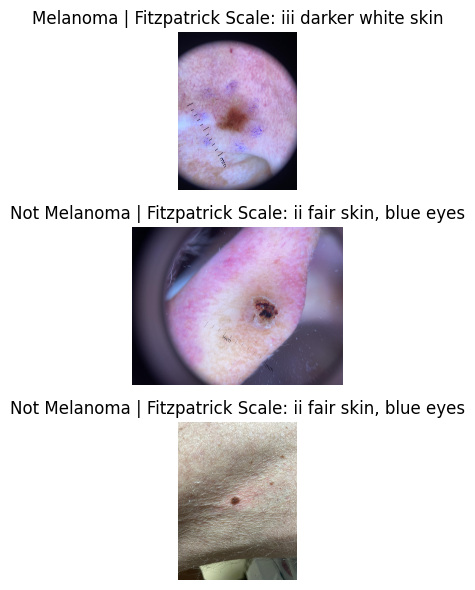

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

# Reload your dataset (replace 'file_path' with your actual dataset path)
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Select 3 random samples from the dataset
sample_df = df.sample(n=3, random_state=35)  # Change random_state for different samples

# Create figure with 3 vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(3, 6))

for i, (_, row) in enumerate(sample_df.iterrows()):
    image_path = os.path.join(image_dir, row["midas_file_name"])
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Get labels
    melanoma_label = "Melanoma" if row["midas_melanoma"].lower() == "yes" else "Not Melanoma"
    fitzpatrick_value = row["midas_fitzpatrick"]  # Fitzpatrick scale value

    # Display image
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"{melanoma_label} | Fitzpatrick Scale: {fitzpatrick_value}", fontsize=12)

plt.tight_layout()
plt.show()

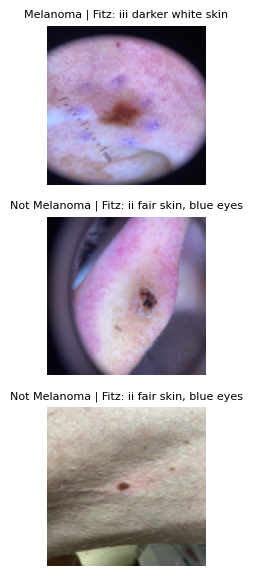

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

# Reload your dataset (replace 'file_path' with your actual dataset path)
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Select 3 random samples from the dataset
sample_df = df.sample(n=3, random_state=35)  # Change random_state for different samples

# Create figure with 3 vertically stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(3, 6))  # Reduced figure size

for i, (_, row) in enumerate(sample_df.iterrows()):
    image_path = os.path.join(image_dir, row["midas_file_name"])
    
    # Load and resize image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((100, 100))  # Smaller image size (100x100 pixels)

    # Get labels
    melanoma_label = "Melanoma" if row["midas_melanoma"].lower() == "yes" else "Not Melanoma"
    fitzpatrick_value = row["midas_fitzpatrick"]  # Fitzpatrick scale value

    # Display image
    axes[i].imshow(image)
    axes[i].axis("off")  # Hide borders
    axes[i].set_title(f"{melanoma_label} | Fitz: {fitzpatrick_value}", fontsize=8)  # Smaller title

# Reduce extra margins and spacing
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.2)  
plt.show()


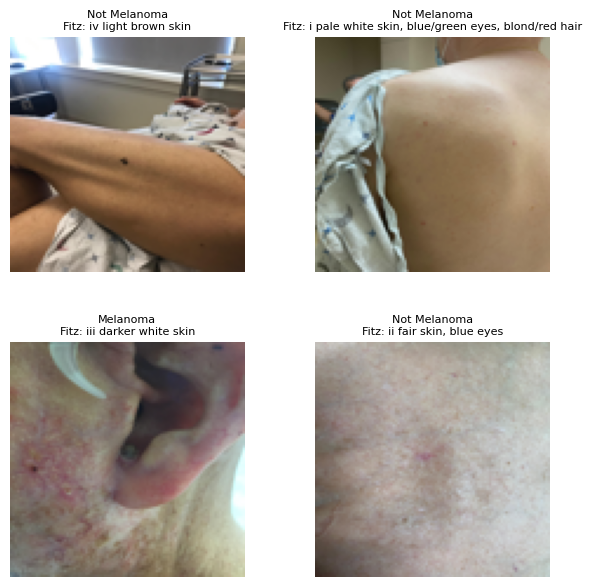

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

# Reload dataset (replace 'file_path' with your actual dataset path)
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Ensure Fitzpatrick values are unique
unique_fitz_df = df.drop_duplicates(subset=["midas_fitzpatrick"])  # Keep unique Fitzpatrick scale values

# Select 4 images with different Fitzpatrick values
if len(unique_fitz_df) >= 4:
    sample_df = unique_fitz_df.sample(n=4, random_state=30)  # Select 4 unique samples
else:
    raise ValueError("Not enough unique Fitzpatrick scale values in the dataset!")

# Create figure with 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(6, 6))  # Square layout (2 rows, 2 columns)

# Loop through selected images and display them
for i, (ax, (_, row)) in enumerate(zip(axes.flat, sample_df.iterrows())):
    image_path = os.path.join(image_dir, row["midas_file_name"])
    
    # Load and resize image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((100, 100))  # Resize to 100x100 pixels

    # Get labels
    melanoma_label = "Melanoma" if row["midas_melanoma"].lower() == "yes" else "Not Melanoma"
    fitzpatrick_value = row["midas_fitzpatrick"]  # Fitzpatrick scale value

    # Display image
    ax.imshow(image)
    ax.axis("off")  # Hide borders
    ax.set_title(f"{melanoma_label}\nFitz: {fitzpatrick_value}", fontsize=8)  # Smaller title

# Adjust layout for a compact appearance
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)  
plt.show()

